In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from qso_sample import QSOSample
import dipole
import multipoles
from estimate_shot_noise import noise_overdensity_map

### $\mu$ map

In [5]:
catdir = '/scratch/aew492/quasars/catalogs'
nside = 64
d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
                        mask_fn=os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits'),
                        mag='G', maglim=20.,
                        blim=30,
                        NSIDE=nside)
selfunc_fn = os.path.join(catdir, f'quaia/selfuncs/selection_function_NSIDE{nside}_G20.0_blim15.fits')

# cut galactic plane, magnitude, and load selection function
d.cut_mag()
d.cut_galactic_plane_hpx()
selfunc = d.get_selfunc(selfunc=selfunc_fn)

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut G > 20.0 -> 755850 sources left.
cut |b| <= 30 based on healpix mask -> 530559 sources left.


In [9]:
# get masked datamaps
masked_datamap_uncorr = d.construct_masked_datamap(selfunc=None, return_map=True)
masked_datamap = d.construct_masked_datamap(selfunc=selfunc, return_map=True)
mask = d.mask

selection function not provided; assuming completeness = 1 in every pixel


In [12]:
# expected number of quasars in each pixel
masked_datamap_uncorr = d.construct_masked_datamap(selfunc=None, return_map=True)
print(f"mean density in masked map, uncorrected = {np.nanmean(masked_datamap_uncorr):.2f} quasars per healpixel", flush=True)
# get masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=selfunc, return_map=True)
# mask and mean density
mask = d.mask
print(f"mean density in masked map, corrected = {np.nanmean(masked_datamap):.2f} quasars per healpixel", flush=True)
# expected number of quasars in each pixel
expected_map = np.nanmean(masked_datamap) * selfunc
print(f"mean density in expected map = {np.nanmean(expected_map):.2f} quasars per healpixel", flush=True)

selection function not provided; assuming completeness = 1 in every pixel
mean density in masked map, uncorrected = 22.15 quasars per healpixel
mean density in masked map, corrected = 33.60 quasars per healpixel
mean density in expected map = 13.73 quasars per healpixel


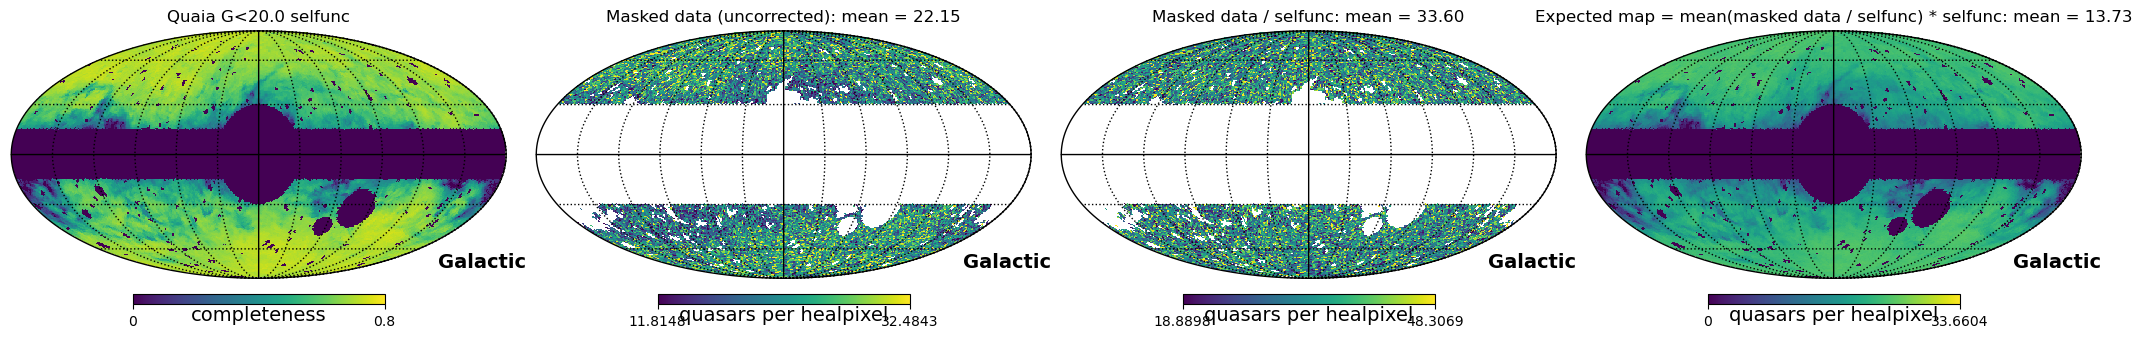

In [16]:
# test each function on the same map realization
fig = plt.figure(figsize=(21,3))
kwargs = dict(coord=['C','G'], badcolor='w', fig=fig)
hp.mollview(selfunc, sub=(1,4,1), title=r'Quaia G<20.0 selfunc', cmap='viridis',
            min=0, max=0.8, unit='completeness', **kwargs)
mean, std = np.nanmean(masked_datamap_uncorr), np.nanstd(masked_datamap_uncorr)
hp.mollview(masked_datamap_uncorr, sub=(1,4,2), title=r'Masked data (uncorrected): mean = 'f'{mean:.2f}', cmap='viridis',
            min=np.max([0, mean-2*std]), max=mean+2*std, unit='quasars per healpixel', **kwargs)
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.mollview(masked_datamap, sub=(1,4,3), title=r'Masked data / selfunc: mean = 'f'{mean:.2f}', cmap='viridis',
            min=np.max([0,mean-2*std]), max=mean+2*std, unit='quasars per healpixel', **kwargs)
mean, std = np.nanmean(expected_map), np.nanstd(expected_map)
hp.mollview(expected_map, sub=(1,4,4), title=r'Expected map = mean(masked data / selfunc) * selfunc: mean = 'f'{mean:.2f}', cmap='viridis',
           min=np.max([0,mean-2*std]), max=mean+2*std, unit='quasars per healpixel', **kwargs)
hp.graticule()

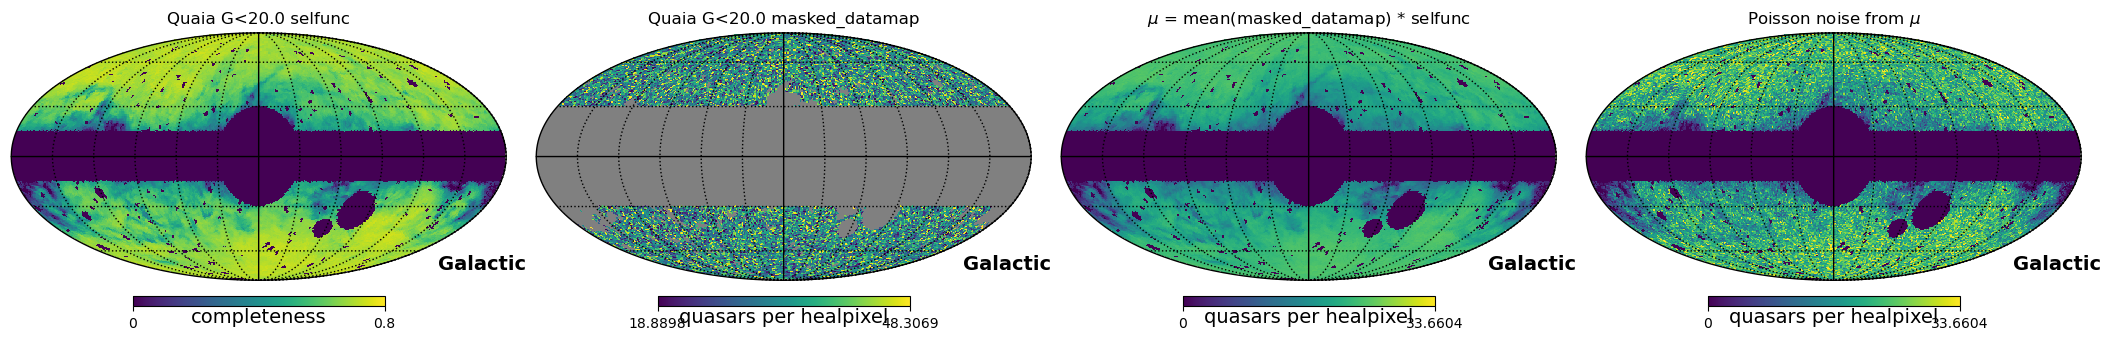

In [8]:
# test each function on the same map realization
fig = plt.figure(figsize=(21,3))
hp.mollview(selfunc, sub=(1,4,1), coord=['C','G'], title=r'Quaia G<20.0 selfunc', fig=fig, cmap='viridis',
            min=0, max=0.8, unit='completeness')
mean, std = np.nanmean(masked_datamap), np.nanstd(masked_datamap)
hp.mollview(masked_datamap, sub=(1,4,2), coord=['C','G'], title=r'Quaia G<20.0 masked_datamap', fig=fig, cmap='viridis',
            min=np.max([0, mean-2*std]), max=mean+2*std, unit='quasars per healpixel')
mean, std = np.nanmean(mu), np.nanstd(mu)
hp.mollview(mu, sub=(1,4,3), coord=['C','G'], title=r'$\mu$ = mean(masked_datamap) * selfunc', fig=fig, cmap='viridis',
            min=np.max([0,mean-2*std]), max=mean+2*std, unit='quasars per healpixel')
noise = tools.generate_noise_map(mu, nside)
hp.mollview(noise, sub=(1,4,4), coord=['C','G'], title=r'Poisson noise from $\mu$', fig=fig, cmap='viridis',
           min=0, max=mean+2*std, unit='quasars per healpixel')
hp.graticule()

In [37]:
cutmask = (selfunc == 0)
sum(cutmask)

6745

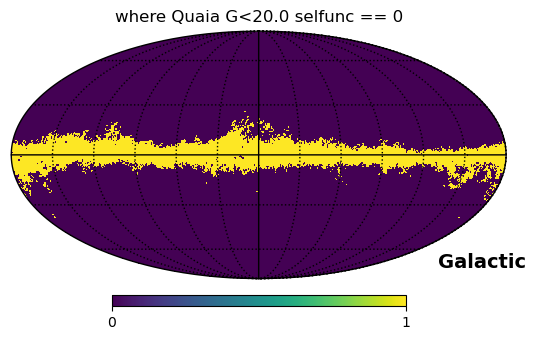

In [39]:
fig = plt.figure(figsize=(12,3))
hp.mollview(cutmask, sub=(1,2,1), coord=['C','G'], title=r'where Quaia G<20.0 selfunc == 0', fig=fig, cmap='viridis',
            min=0, max=1)
hp.graticule()

In [40]:
# compare selection functions
selfunc1 = d.get_selfunc(os.path.join(catdir, f'quaia/selfuncs/selection_function_NSIDE{nside}_G20.0.fits'))
selfunc2 = d.get_selfunc(os.path.join(catdir, f'quaia/selfuncs/selection_function_NSIDE{nside}_G20.0_blim15.fits'))

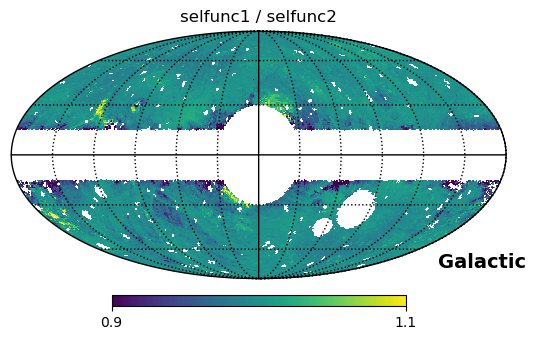

In [53]:
fig = plt.figure(figsize=(12,3))
ratio = np.divide(selfunc1, selfunc2, out=np.full_like(selfunc1, np.nan), where=(selfunc2 != 0.))
hp.mollview(ratio, sub=(1,2,1), coord=['C','G'], title=r'selfunc1 / selfunc2', fig=fig, cmap='viridis', badcolor='w',
           min=0.9, max=1.1)
hp.graticule()

### $C_1$ convergence

In [4]:
# convergence: dipole measured on the full sky
ntrials = 10000

#### Quaia

In [5]:
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax1_{ntrials}trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment'])

# check additional max ells
max_ells = [2,3]
Cells_higher = []
for i, max_ell_ in enumerate(max_ells):
    res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax{max_ell_}_{ntrials}trials.npy',
                        allow_pickle=True).item()
    Cells_higher.append(res['Cells_fullsky'])
    assert np.all(res['ntrials'] == ntrialss)
    # assert res['mu'] == mu

Quaia G<20.0, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq


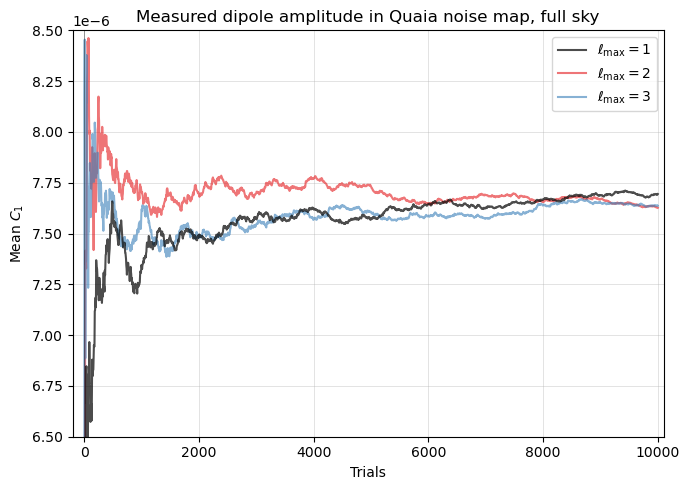

In [6]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
colors = list(map(mpl.cm.Set1, range(len(max_ells))))
for i, max_ell_ in enumerate(max_ells):
    ax.plot(ntrialss, Cells_higher[i][:,0], ls='-', c=colors[i], alpha=0.6, label=r'$\ell_\mathrm{max}=$'f'{max_ell_}')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(6.5e-6, 8.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in Quaia noise map, full sky')
ax.legend()

In [7]:
start = 2000
C1_fullsky_quaia = np.mean(Cells1[:,0][ntrialss > start])
print(C1_fullsky_quaia)
for Cells_ in Cells_higher:
    print(np.mean(Cells_[:,0][ntrialss > start]))

7.621112129451388e-06
7.692500108012535e-06
7.5964099347525935e-06


#### CatWISE AGNs

In [8]:
res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax1_{ntrials}trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment'])

# check additional max ells
max_ells = [2,3]
Cells_higher = []
for i, max_ell_ in enumerate(max_ells):
    res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax{max_ell_}_{ntrials}trials.npy',
                        allow_pickle=True).item()
    Cells_higher.append(res['Cells_fullsky'])
    assert np.all(res['ntrials'] == ntrialss)
    assert res['mu'] == mu

CatWISE AGNs, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq


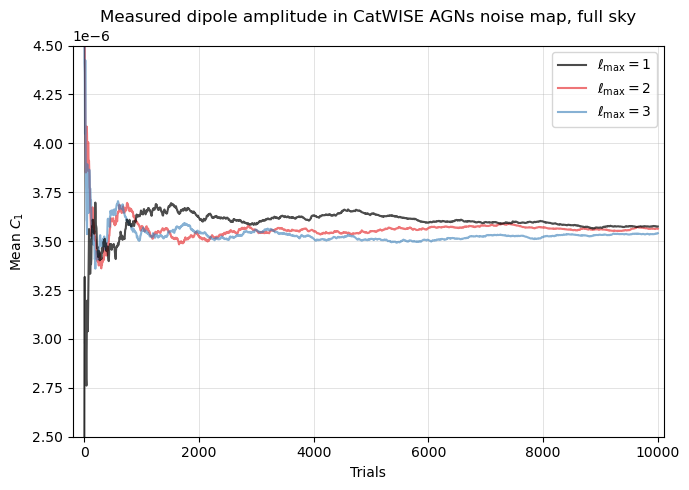

In [9]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
colors = list(map(mpl.cm.Set1, range(len(max_ells))))
for i, max_ell_ in enumerate(max_ells):
    ax.plot(ntrialss, Cells_higher[i][:,0], ls='-', c=colors[i], alpha=0.6, label=r'$\ell_\mathrm{max}=$'f'{max_ell_}')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(2.5e-6, 4.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in CatWISE AGNs noise map, full sky')
ax.legend()

In [10]:
start = 2000
C1_fullsky_catwise = np.mean(Cells1[:,0][ntrialss > start])
print(C1_fullsky_catwise)
for Cells_ in Cells_higher:
    print(np.mean(Cells_[:,0][ntrialss > start]))

3.6047530454249946e-06
3.558693543048595e-06
3.5232599508410313e-06


### $C_1$: shot noise on full sky up to $\ell_\mathrm{max}$

In [11]:
# shot noise on full sky, up to some max ell, average of n trials
max_ell = 8
ntrials = 2000

# Quaia
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax{max_ell}_{ntrials}trials.npy',
                        allow_pickle=True).item()
ells = res['ells']
Cells_trials_quaia = res['Cells_fullsky']
ntrialss = res['ntrials']

# CatWISE
res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax{max_ell}_{ntrials}trials.npy',
                        allow_pickle=True).item()
assert np.all(res['ells'] == ells)
assert np.all(res['ntrials'] == ntrialss)
Cells_trials_catwise = res['Cells_fullsky']

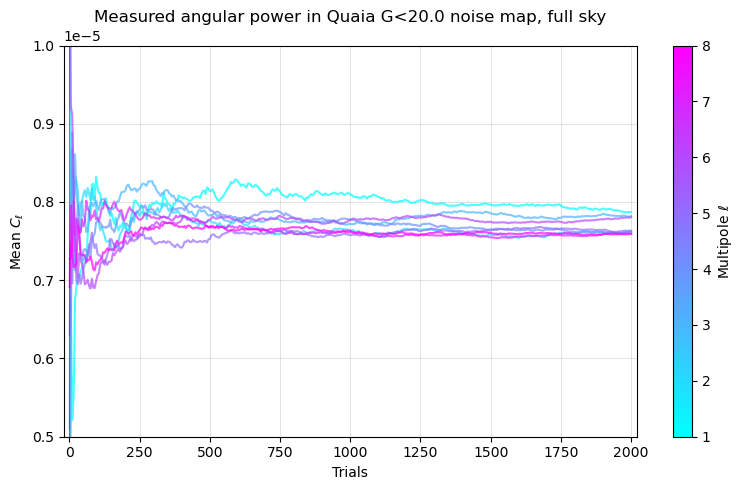

In [12]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
# colors = list(map(mpl.cm.cool, range(max_ell)))
norm = mpl.colors.Normalize(vmin=1, vmax=max_ell)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')
for i, ell in enumerate(range(1, max_ell+1)):
    ax.plot(ntrialss, Cells_trials_quaia[:,i], c=smap.to_rgba(ell), ls='-', alpha=0.7)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-20, 2020)
ax.set_ylim(5e-6, 1e-5)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_\ell$')
ax.set_title('Measured angular power in Quaia G<20.0 noise map, full sky')
fig.colorbar(smap, ax=ax, label=r'Multipole $\ell$')

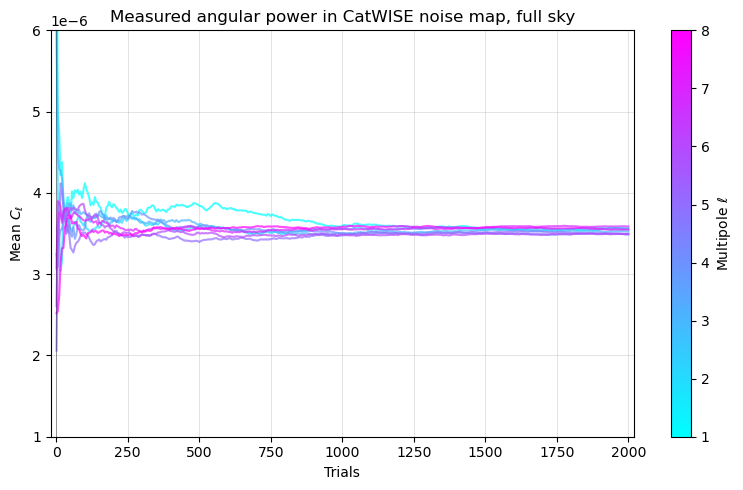

In [13]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
# colors = list(map(mpl.cm.cool, range(max_ell)))
norm = mpl.colors.Normalize(vmin=1, vmax=max_ell)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')
for i, ell in enumerate(ells):
    ax.plot(ntrialss, Cells_trials_catwise[:,i], c=smap.to_rgba(ell), ls='-', alpha=0.7)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-20, 2020)
ax.set_ylim(1e-6, 6e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_\ell$')
ax.set_title('Measured angular power in CatWISE noise map, full sky')
fig.colorbar(smap, ax=ax, label=r'Multipole $\ell$')

Text(0.5, 1.0, 'Shot noise estimates on the full sky (mean of 2000 trials)')

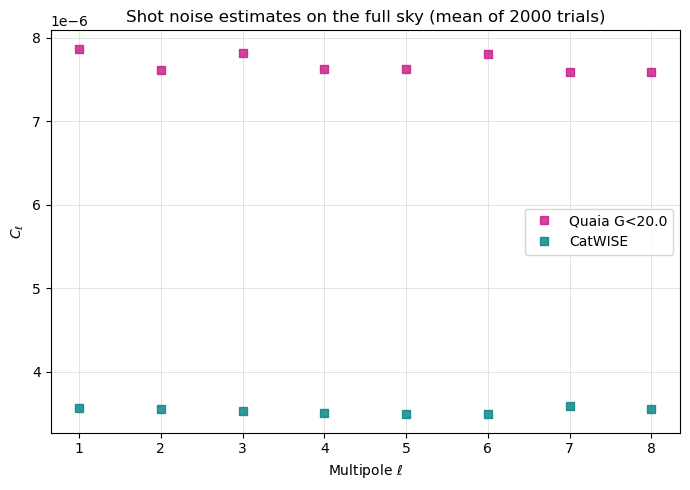

In [14]:
# compare both, mean of all trials
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ells, Cells_trials_quaia[-1,:], marker='s', ls='None', c='mediumvioletred', alpha=0.8, label='Quaia G<20.0')
ax.plot(ells, Cells_trials_catwise[-1,:], marker='s', ls='None', c='teal', alpha=0.8, label='CatWISE')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.legend()
ax.set_title(f'Shot noise estimates on the full sky (mean of {ntrials} trials)')

### $C_1$: shot noise cut sky with $\Lambda$ regularization

In [15]:
max_ells = np.arange(1, 9).astype(int)
ntrials = 500

#### Quaia

In [16]:
cutsky_res = []
cutsky_res_fine = []
Lambdas_closest_quaia = np.empty(len(max_ells))
stds_closest = np.empty_like(Lambdas_closest_quaia)
for i, max_ell in enumerate(max_ells):
    res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_cutsky_ellmax{max_ell}_{ntrials}trials_Lambda.npy',
                      allow_pickle=True).item()
    Lambdas, Cells_cut, stds = list(zip(*res_cut['Cells_cutsky']))
    idx_sorted = np.array(Lambdas).argsort()
    Lambdas, C1s_cut = np.array(Lambdas)[idx_sorted], np.array(Cells_cut)[idx_sorted][:,0] # to get C_1 only
    stds = np.array(stds)[idx_sorted][:,0] # standard deviation of the trials
    cutsky_res.append(np.array([Lambdas, C1s_cut, stds]))
    # interpolate on a finer grid
    Lambdas_fine = np.logspace(np.log10(min(Lambdas)), np.log10(max(Lambdas)), 1001)
    C1s_cut_fine = np.interp(Lambdas_fine, Lambdas, C1s_cut)
    cutsky_res_fine.append(np.array([Lambdas_fine, C1s_cut_fine]))
    # find closest Wmask in the interpolated list to the C_1 on the full sky
    idx_closest = np.abs(C1s_cut_fine - C1_fullsky_quaia).argmin()
    Lambdas_closest_quaia[i] = Lambdas_fine[idx_closest]

Text(0.5, 1.0, 'Quaia G<20.0 measured shot noise dipole vs. regularization')

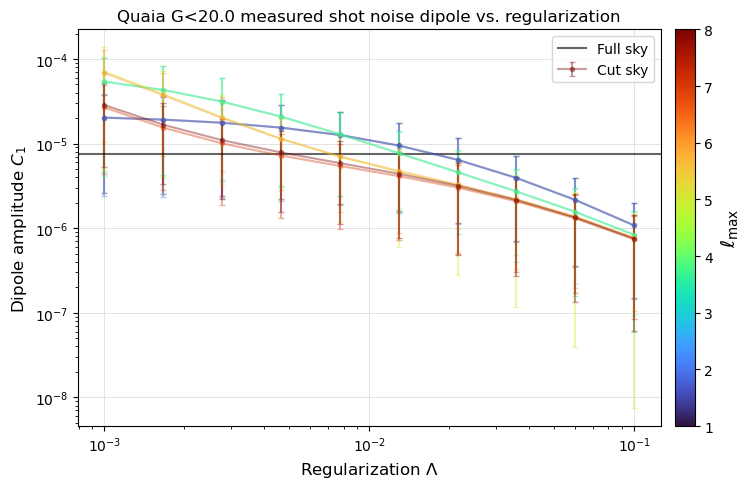

In [17]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, max_ell in enumerate(max_ells):
    Lambdas, C1s_cut, stds = cutsky_res[i]
    label = 'Cut sky' if i==max(max_ells)-1 else ''
    ax.errorbar(Lambdas, C1s_cut, yerr=stds, capsize=2, marker='.', c=smap.to_rgba(max_ell), alpha=0.4, label=label)
    # ax.axhline(C1s_fullsky[i], c=smap.to_rgba(max_ell), alpha=0.6)
ax.axhline(C1_fullsky_quaia, c='k', alpha=0.6, label='Full sky')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
cbar = fig.colorbar(smap, ax=ax, ticks=max_ells.astype(int), pad=.02)
cbar.set_label(label=r'$\ell_\mathrm{max}$', fontsize=14)
ax.legend()
ax.set_title('Quaia G<20.0 measured shot noise dipole vs. regularization')

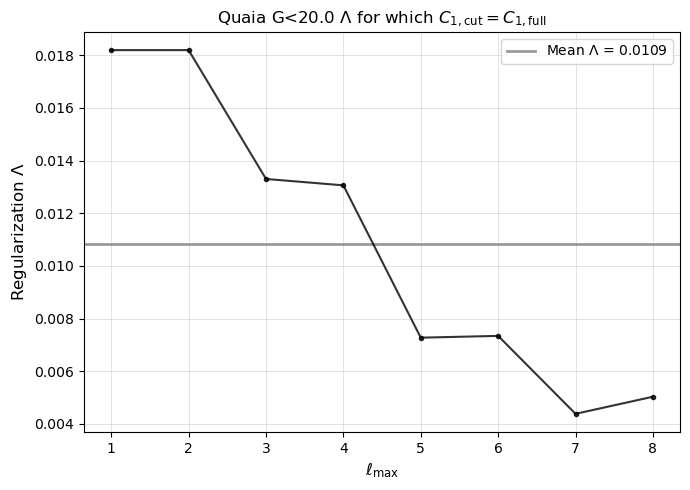

In [18]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_closest_quaia, c='k', alpha=0.8, marker='.', zorder=10)
ax.axhline(np.mean(Lambdas_closest_quaia), c='grey', alpha=0.8, lw=2,
           label=r'Mean $\Lambda$ = 'f'{np.mean(Lambdas_closest_quaia):.4f}')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'Quaia G<20.0 $\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

In [19]:
Lambdas_closest_quaia

array([0.01819701, 0.01819701, 0.01330454, 0.01306171, 0.0072778 ,
       0.00734514, 0.00438531, 0.00503501])

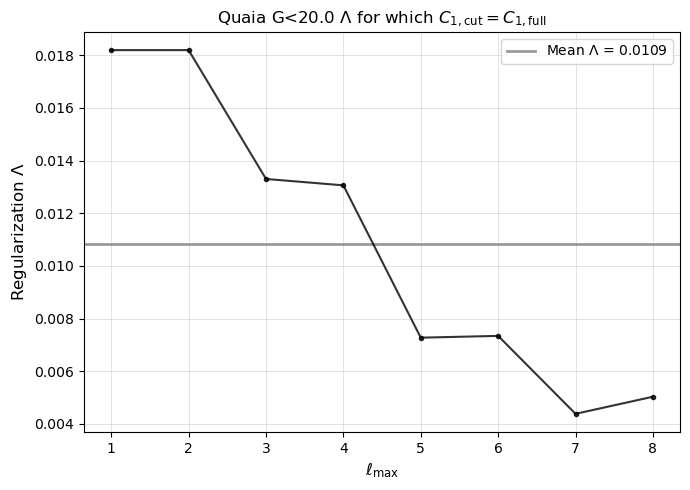

In [20]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_closest_quaia, c='k', alpha=0.8, marker='.', zorder=10)
ax.axhline(np.mean(Lambdas_closest_quaia), c='grey', alpha=0.8, lw=2,
           label=r'Mean $\Lambda$ = 'f'{np.mean(Lambdas_closest_quaia):.4f}')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'Quaia G<20.0 $\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

In [21]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_closest_quaia))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_quaia_noise-matched.npy'
np.save(save_fn, res)

#### CatWISE AGNs

In [22]:
cutsky_res = []
cutsky_res_fine = []
Lambdas_closest_catwise = np.empty(len(max_ells))
stds_closest = np.empty_like(Lambdas_closest_catwise)
for i, max_ell in enumerate(max_ells):
    res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_cutsky_ellmax{max_ell}_{ntrials}trials_Lambda.npy',
                      allow_pickle=True).item()
    Lambdas, Cells_cut, stds = list(zip(*res_cut['Cells_cutsky']))
    idx_sorted = np.array(Lambdas).argsort()
    Lambdas, C1s_cut = np.array(Lambdas)[idx_sorted], np.array(Cells_cut)[idx_sorted][:,0] # to get C_1 only
    stds = np.array(stds)[idx_sorted][:,0] # standard deviation of the trials
    cutsky_res.append(np.array([Lambdas, C1s_cut, stds]))
    # interpolate on a finer grid
    Lambdas_fine = np.logspace(np.log10(min(Lambdas)), np.log10(max(Lambdas)), 101)
    C1s_cut_fine = np.interp(Lambdas_fine, Lambdas, C1s_cut)
    cutsky_res_fine.append(np.array([Lambdas_fine, C1s_cut_fine]))
    # find closest Lambda in the interpolated list to the C_1 on the full sky
    idx_closest = np.abs(C1s_cut_fine - C1_fullsky_catwise).argmin()
    Lambdas_closest_catwise[i] = Lambdas_fine[idx_closest]

Text(0.5, 1.0, 'CatWISE AGNs measured shot noise dipole vs. regularization')

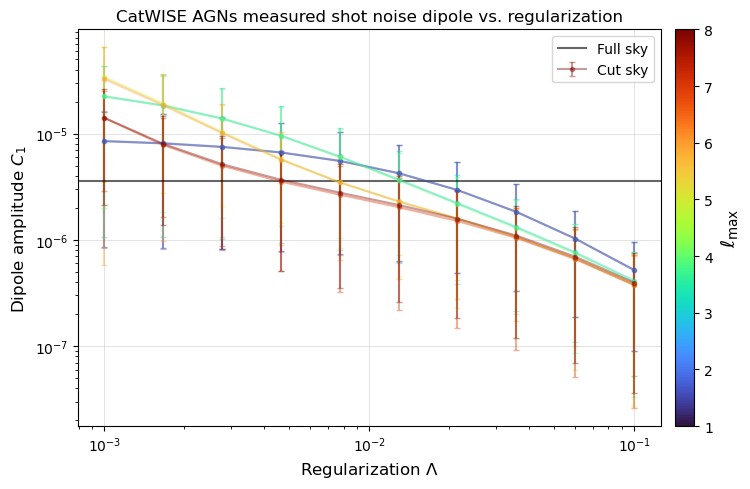

In [23]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, max_ell in enumerate(max_ells):
    Lambdas, C1s_cut, stds = cutsky_res[i]
    label = 'Cut sky' if i==max(max_ells)-1 else ''
    ax.errorbar(Lambdas, C1s_cut, yerr=stds, capsize=2, marker='.', c=smap.to_rgba(max_ell), alpha=0.4, label=label)
    # ax.axhline(C1s_fullsky[i], c=smap.to_rgba(max_ell), alpha=0.6)
ax.axhline(C1_fullsky_catwise, c='k', alpha=0.6, label='Full sky')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
cbar = fig.colorbar(smap, ax=ax, ticks=max_ells.astype(int), pad=.02)
cbar.set_label(label=r'$\ell_\mathrm{max}$', fontsize=14)
ax.legend()
ax.set_title('CatWISE AGNs measured shot noise dipole vs. regularization')

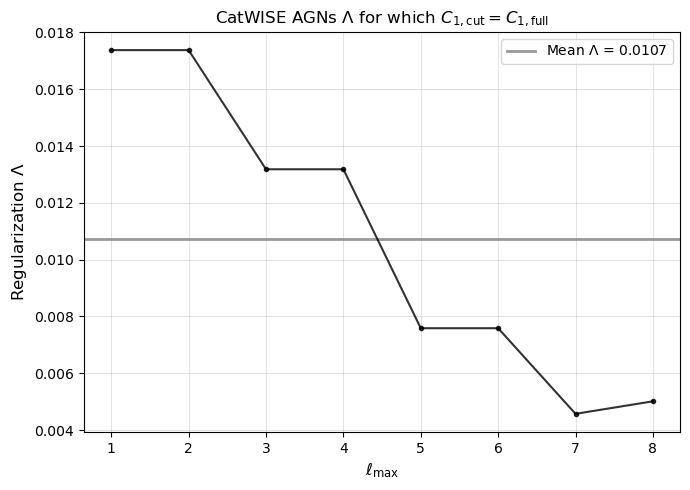

In [24]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_closest_catwise, c='k', alpha=0.8, marker='.', zorder=10)
ax.axhline(np.mean(Lambdas_closest_catwise), c='grey', alpha=0.8, lw=2,
           label=r'Mean $\Lambda$ = 'f'{np.mean(Lambdas_closest_catwise):.4f}')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'CatWISE AGNs $\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

In [25]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_closest_catwise))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_catwise_noise-matched.npy'
np.save(save_fn, res)

#### compare

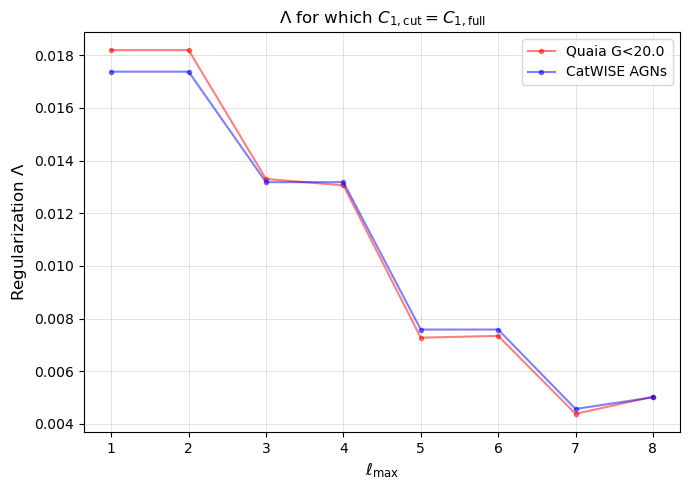

In [26]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_closest_quaia, c='r', alpha=0.5, marker='.', label='Quaia G<20.0')
ax.plot(max_ells, Lambdas_closest_catwise, c='b', alpha=0.5, marker='.', label='CatWISE AGNs')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'$\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

### $\mathcal{D}$ convergence

#### Quaia

In [17]:
# full sky

ntrials = 10000

res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_dipole_amps_fullsky_{ntrials}trials.npy',
                        allow_pickle=True).item()
dipole_amps = res['dipole_amps']
ntrials = res['ntrials']
mu = res['mu']
print(res['comment'])

# compare to C1
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax1_{ntrials}trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells']
ntrials_C1 = res['ntrials']
assert res['mu'] == mu

Quaia G<20.0, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq


In [18]:
mu

33.598334286596995

In [19]:
# convert dipole amps to C1
C1s_from_D = tools.C1_from_D(dipole_amps)

In [20]:
np.mean(C1s_from_D), np.mean(Cells1)

(7.654881535428059e-06, 7.62645282179222e-06)

In [21]:
# look at convergence
C1s_from_D_means = np.array([
    np.mean(C1s_from_D[:i+1]) for i in range(ntrials)
])
Cells1_means = np.array([
    np.mean(Cells1[:i+1]) for i in range(ntrials_C1)
])

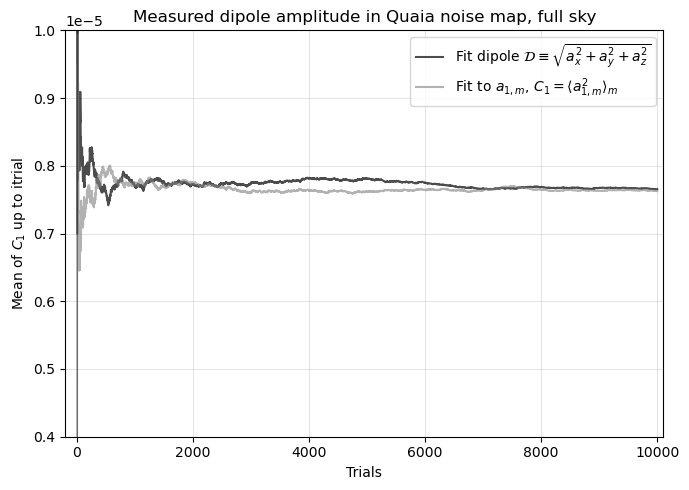

In [24]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(np.arange(ntrials), C1s_from_D_means, 'k-', alpha=0.7, label=r'Fit dipole $\mathcal{D}\equiv\sqrt{a_x^2+a_y^2+a_z^2}$')
ax.plot(np.arange(ntrials_C1), Cells1_means, ls='-', c='grey', alpha=0.6, label=r'Fit to $a_{1,m}$, $C_1=\langle a_{1,m}^2\rangle_m$')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(4e-6, 1e-5)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean of $C_1$ up to itrial')
ax.set_title('Measured dipole amplitude in Quaia noise map, full sky')
ax.legend()

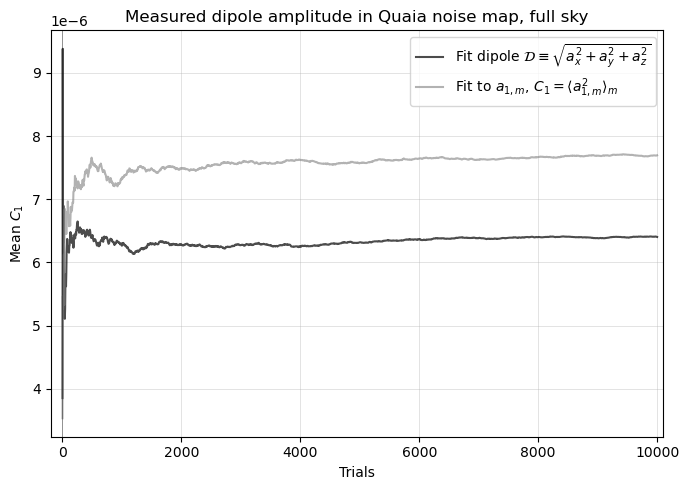

In [56]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ntrialss, C_1(dipole_amps), 'k-', alpha=0.7, label=r'Fit dipole $\mathcal{D}\equiv\sqrt{a_x^2+a_y^2+a_z^2}$')
ax.plot(ntrialss_C1, Cells1[:,0], ls='-', c='grey', alpha=0.6, label=r'Fit to $a_{1,m}$, $C_1=\langle a_{1,m}^2\rangle_m$')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
# ax.set_ylim(6.5e-6, 8.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in Quaia noise map, full sky')
ax.legend()

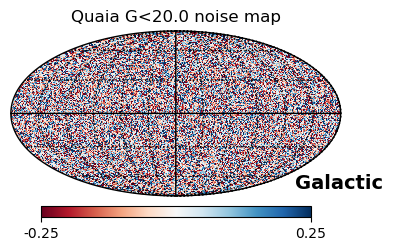

In [57]:
# the above should converge to the same value...
# test each function on the same map realization
noise_map = noise_overdensity_map(mu)
fig = plt.figure(figsize=(11,2))
hp.mollview(noise_map, sub=(1,2,1), coord=['C','G'], title=r'Quaia G<20.0 noise map', fig=fig, cmap='RdBu', min=-0.25, max=0.25)
hp.graticule()

In [58]:
# C1 function
ells, Cells_fullsky, alms = multipoles.compute_Cells_in_overdensity_map_Lambda(noise_map,
                                                                    Lambda=0., max_ell=1, return_alms=True)
# dipole function
dipole_comps = dipole.measure_dipole_in_overdensity_map_Lambda(noise_map, Lambda=0.)
# and compare to healpy
hp_dipole_comps = hp.fit_dipole(noise_map)

In [59]:
print("Cells =\t\t", Cells_fullsky,"\nalms =\t\t", alms,"\ndipole comps =\t", dipole_comps,"\nfrom healpy =\t", hp_dipole_comps)

Cells =		 [1.15921664e-31 1.65439860e-06] 
alms =		 [3.40472706e-16 7.74590973e-04 6.00662549e-04 2.00060219e-03] 
dipole comps =	 [0.0009775  0.00037847 0.00029349] 
from healpy =	 (9.539729228945066e-17, array([0.0009775 , 0.00037847, 0.00029349]))


In [60]:
# do the dipole components convert to the a1ms like we expect?
tools.a1ms_to_dipole_comps(alms[1:])

array([0.0009775 , 0.00037847, 0.00029349])

In [62]:
# yes!

In [67]:
# do the sum of the squares of the a1ms match C1?
np.sum(alms[1:]**2) / 3, Cells_fullsky[1], np.allclose(np.sum(alms[1:]**2) / 3, Cells_fullsky[1])

(1.654398598221693e-06, 1.654398598221693e-06, True)

In [68]:
# yes!

In [70]:
# does the C_1( norm of the dipole components ) match C1 ?
Cells_fullsky[1], C_1(np.linalg.norm(dipole_comps)), np.allclose(Cells_fullsky[1], C_1(np.linalg.norm(dipole_comps)))

(1.654398598221693e-06, 1.6543985982216734e-06, True)

In [71]:
# yes! so what's the problem ???

#### cut sky

In [35]:
# cut sky
res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_dipole_amps_cutsky_1000trials_Lambda.npy',
                  allow_pickle=True).item()
Lambdas_D = res_cut['Lambdas']
dipole_amps_cut = res_cut['dipole_amps_cutsky']
stds_D = res_cut['stds']
assert res_cut['mu'] == mu

# compare to C1
res_cut_C1 = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_cutsky_ellmax1_500trials_Lambda.npy',
                      allow_pickle=True).item()
Lambdas_C1, Cells_cut_C1, stds_C1 = list(zip(*res_cut_C1['Cells_cutsky']))
idx_sorted = np.array(Lambdas_C1).argsort()
Lambdas_C1, C1s_cut = np.array(Lambdas_C1)[idx_sorted], np.array(Cells_cut_C1)[idx_sorted][:,0] # to get C_1 only
stds_C1 = np.array(stds_C1)[idx_sorted][:,0] # standard deviation of the trials

Text(0.5, 1.0, 'Quaia G<20.0 measured shot noise dipole vs. regularization')

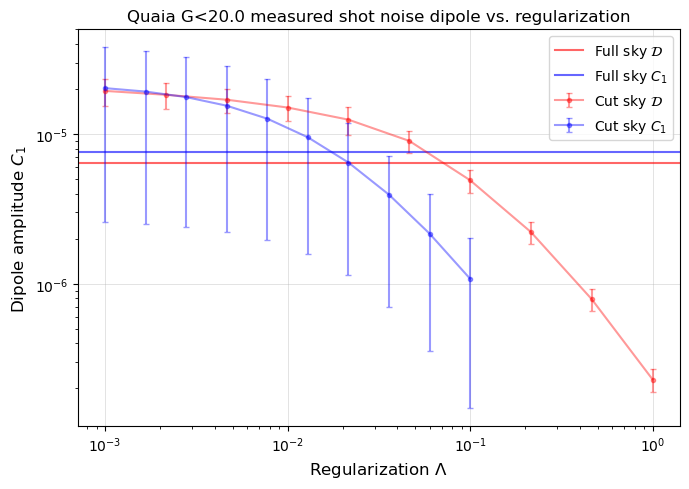

In [36]:
# plot
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.errorbar(Lambdas_D, C_1(dipole_amps_cut), yerr=C_1(stds_D), capsize=2, marker='.', c='r', ls='-', alpha=0.4, label=r'Cut sky $\mathcal{D}$')
ax.axhline(C_1(dipole_amps[-1]), c='r', alpha=0.6, label=r'Full sky $\mathcal{D}$')
ax.errorbar(Lambdas_C1, C1s_cut, yerr=stds_C1, capsize=2, marker='.', c='b', ls='-', alpha=0.4, label=r'Cut sky $C_1$')
ax.axhline(C1_fullsky_quaia, c='b', alpha=0.6, label=r'Full sky $C_1$')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
ax.legend()
ax.set_title('Quaia G<20.0 measured shot noise dipole vs. regularization')

In [37]:
# closest cut sky D(Lambda) to the full sky amplitude
# interpolate on a finer grid
Lambdas_fine = np.logspace(np.log10(min(Lambdas_D)), np.log10(max(Lambdas_D)), 101)
Ds_cut_fine = np.interp(Lambdas_fine, Lambdas_D, dipole_amps_cut)
# find closest Lambda in the interpolated list to D on the full sky
idx_closest = np.abs(Ds_cut_fine - dipole_amps[-1]).argmin()
Lambda_closest_quaia_D = Lambdas_fine[idx_closest]

# same for C1
Lambdas_fine = np.logspace(np.log10(min(Lambdas_C1)), np.log10(max(Lambdas_C1)), 101)
C1s_cut_fine = np.interp(Lambdas_fine, Lambdas_C1, C1s_cut)
# find closest Lambda in the interpolated list to the C_1 on the full sky
idx_closest = np.abs(C1s_cut_fine - C1_fullsky_quaia).argmin()
Lambda_closest_quaia_C1 = Lambdas_fine[idx_closest]

In [38]:
Lambda_closest_quaia_D, Lambda_closest_quaia_C1

(0.07762471166286915, 0.018197008586099832)